# Perkenalan


   ==============================================
   
   Milestone 2

    Nama  : Nugroho Wicaksono
    Batch : FTDS-029

    Program ini dibuat untuk membuat sebuah machine learning yang mempredeksi tingkat obesitas selain dari faktor BMI
    yang bisa menimbulkan bias. setelah itu jika terbukti obesitas akan diberikan tingkat obesitasnya.
    
   ==============================================

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.outliers import Winsorizer

from scipy.stats import kendalltau, chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline as sklPipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay,f1_score

from imblearn.over_sampling import SMOTENC

import pickle



# Data Loading

> sebelum melakukan analysis, terlebih dahulu mengambil dataset melalui read file CSV yang tersedia

In [2]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
df.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
#Duplicated Dataset

df_dupe = df.copy()

ada baiknya kita membuat copy dari dataframe original. sehingga data asli tidak berubah ubah dan hanya dataframe hasil copy yang digunakan untuk keperluan analysis 

In [4]:
# mencari data duplikat pada datafrme 
df_dupe.duplicated().sum()

np.int64(24)

terdapat 24 baris data yang duplikat pada dataset **df_dupe**

In [5]:
# drop semua data duplikat 
df_dupe = df_dupe.drop_duplicates()

In [6]:
# reset index setelah droping duplicate data
df_dupe = df_dupe.reset_index(drop=True)
df_dupe

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2083,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2084,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2085,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [7]:
# mencari data duplikat pada datafrme 
df_dupe.duplicated().sum()

np.int64(0)

cek kembali untuk memastikan tidak ada duplikat

In [8]:
# melihat total dari missing value masing masing kolom
df_dupe.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

dari 17 kolom tidak ada missing value

In [9]:
#check dataset
df_dupe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2087 non-null   object 
 1   Age                             2087 non-null   float64
 2   Height                          2087 non-null   float64
 3   Weight                          2087 non-null   float64
 4   family_history_with_overweight  2087 non-null   object 
 5   FAVC                            2087 non-null   object 
 6   FCVC                            2087 non-null   float64
 7   NCP                             2087 non-null   float64
 8   CAEC                            2087 non-null   object 
 9   SMOKE                           2087 non-null   object 
 10  CH2O                            2087 non-null   float64
 11  SCC                             2087 non-null   object 
 12  FAF                             20

Kode tersebut mencetak ringkasan struktur DataFrame yang terdiri dari 2.087 baris (indeks 0–2.086) dan 17 kolom, terdapat delapan kolom numerik (float64) dan sembilan kolom kategori/teks (object).

In [10]:
#cek statistik sederhana pada dataset
df_dupe.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2087.0,24.353090,6.368801,14.00,19.915937,22.847618,26.000000,61.00
Height,2087.0,1.702674,0.093186,1.45,1.630178,1.701584,1.769491,1.98
Weight,2087.0,86.858730,26.190847,39.00,66.000000,83.101100,108.015907,173.00
FCVC,2087.0,2.421466,0.534737,1.00,2.000000,2.396265,3.000000,3.00
NCP,2087.0,2.701179,0.764614,1.00,2.697467,3.000000,3.000000,4.00
CH2O,2087.0,2.004749,0.608284,1.00,1.590922,2.000000,2.466193,3.00
FAF,2087.0,1.012812,0.853475,0.00,0.124505,1.000000,1.678102,3.00
TUE,2087.0,0.663035,0.608153,0.00,0.000000,0.630866,1.000000,2.00


ringkasan statistik deskriptif dari kolom–kolom numerik dalam dataset. Output menunjukkan:

- count: jumlah nilai tak kosong (seluruh kolom memiliki 2.087 nilai)

- mean: nilai rata-rata, misalnya usia rata‑rata adalah ~24,35 tahun

- std: simpangan baku, yang menunjukkan sebaran data (usia ±6,37 tahun)

- min dan max: nilai minimum dan maksimum (usia antara 14–61 tahun)

# Exploratory Data Analysis (EDA)

## 1. Apakah mereka yang memonitor kalori (SCC=yes) memiliki aktivitas fisik (FAF = yes) yang berbeda dari mereka yang tidak memonitor kalori (SCC=no)

In [11]:
# lakukan uji korelasi dengan menggunakan kendall 
df_dupe['SCC_bin'] = df_dupe['SCC'].map({'yes':1, 'no':0})

tau, p = kendalltau(df_dupe['SCC_bin'], df_dupe['FAF'])
print(f"Kendall tau = {tau:.3f}, p-value = {p:.3f}")

Kendall tau = 0.054, p-value = 0.003


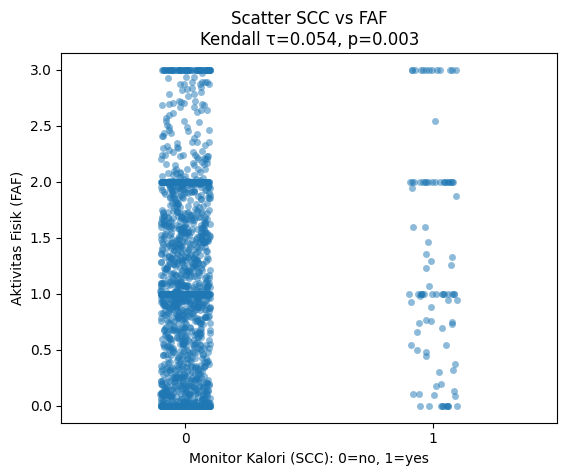

In [12]:
# buat plot untuk tahu uji korelasi 
sns.stripplot(x='SCC_bin', y='FAF', data=df_dupe, jitter=True, alpha=0.5)
plt.xlabel('Monitor Kalori (SCC): 0=no, 1=yes')
plt.ylabel('Aktivitas Fisik (FAF)')
plt.title(f'Scatter SCC vs FAF\nKendall τ={tau:.3f}, p={p:.3f}')
plt.show()

setelah dilakuakan pengujian antara 2 kolom aktifitas fisik(FAF), dengan monitor kalori (SCC), didapati bahwa terdapat korelasi positif meskipun sangat lemah (0.054) tapi karena p value nya (0.000) yang berarti korelasi itu bersifat signifikan. jadi kesimpulan yang didapat adalah mereka yang memonitor kalori kalori cenderung memiliki aktifitas fisik yang lebih tinggi dibanding dengan yang tidak.

## 2. Apakah mereka yang merokok memiliki tingkat obesitas yang lebih tinggi dibanding mereka yang tidak merokok?

In [13]:
# lakukan filtering memisahakan perokok dan tindak perokok
df2 = df_dupe.query("SMOKE == 'yes' or SMOKE == 'no'")


In [14]:


# Tabel frekuensi NObeyesdad vs SMOKE
ct = pd.crosstab(df2['NObeyesdad'], df2['SMOKE'])

# Uji chi-square
chi2, p, dof, expected = chi2_contingency(ct)

print("Chi2:", chi2)
print("p-value:", p)


Chi2: 31.85471978916896
p-value: 1.7397906082796266e-05


dari uji korelasi menggunakan chi korelasi, dapat disimpulkan bahwa distribusi dari jenis obesitas tidak ada hubungannya dengan merokok atau tidak merokok. untuk lebih jelas hasilnya selanjutnya akan digunakan  bar plot untuk melihat distribusi datanya.

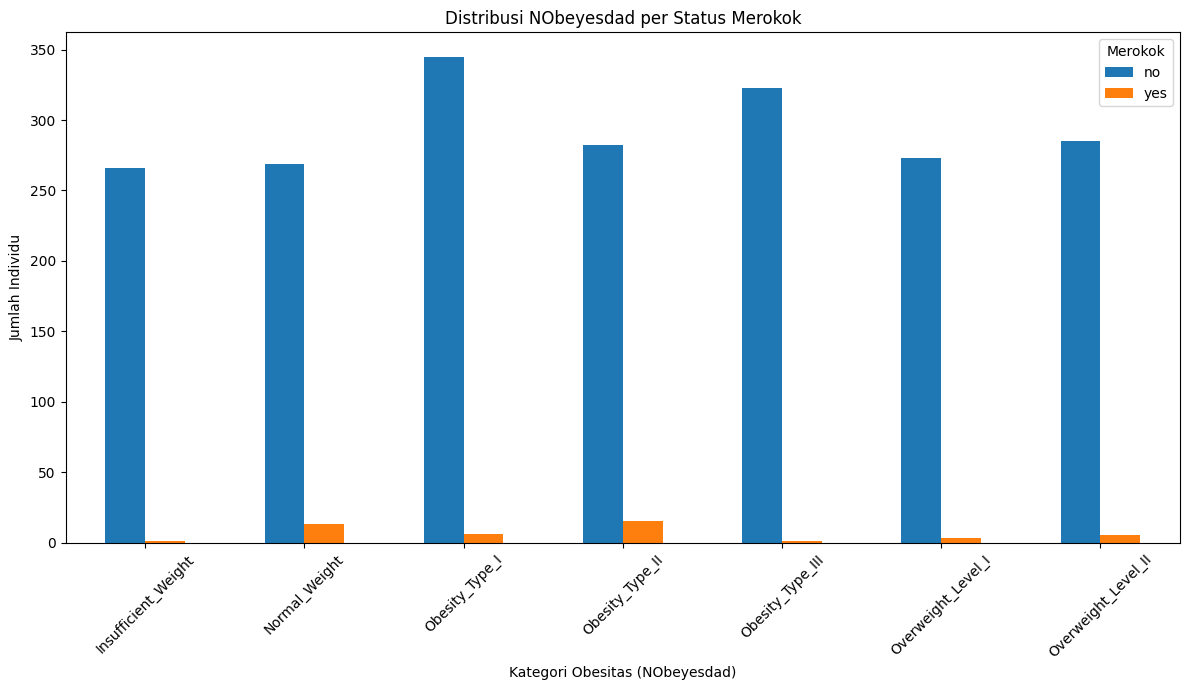

In [15]:
# Plot grouped bar chart
ax = ct.plot(kind='bar', rot=45, figsize=(12,7))
ax.set_xlabel("Kategori Obesitas (NObeyesdad)")
ax.set_ylabel("Jumlah Individu")
ax.set_title("Distribusi NObeyesdad per Status Merokok")
plt.legend(title="Merokok")
plt.tight_layout()
plt.show()

setelah melihat bar barplot diatas. korelasi apakah mereka yang merokok memiliki tingkat obesitas yang lebih tinggi dibanding mereka yang tidak merokok sudah terjawab. tidak ada korelasi dari apakah dia mereka merokok atau tidak dengan tingkat obesitas yang dimiliki.

## 3.apakah mereka yang keluarganya memiliki riwayat obesitas bisa terkena obesitas juga meskipun memiliki pola hidup yang sehat 

In [16]:
# Anggap kategori obesitas: Obesity_Type_I & II
df_dupe['obesity_bin'] = df_dupe['NObeyesdad'].isin(['Obesity_Type_I', 'Obesity_Type_II']).astype(int)
df_dupe['fam_bin'] = (df_dupe['family_history_with_overweight']=='yes').astype(int)

In [17]:
ct = pd.crosstab(df_dupe['fam_bin'], df_dupe['obesity_bin'])

a = ct.loc[1,1]
b = ct.loc[1,0]
c = ct.loc[0,1]
d = ct.loc[0,0]

phi = (a*d - b*c) / ((a+b)*(c+d)*(a+c)*(b+d))**0.5
print('Phi coefficient =', phi)

Phi coefficient = 0.2871403335251952


berdasarkan hasil phi diatas  jika seseorang memiliki riwayat keluarga obesitas, mereka lebih mungkin mengalami obesitas, bahkan ketika gaya hidup tampak sehat. meskipun nilai diatas tidak menujukkan adanya asosiasi lemah jadinya ada faktor lain  yang mempengaruhi.

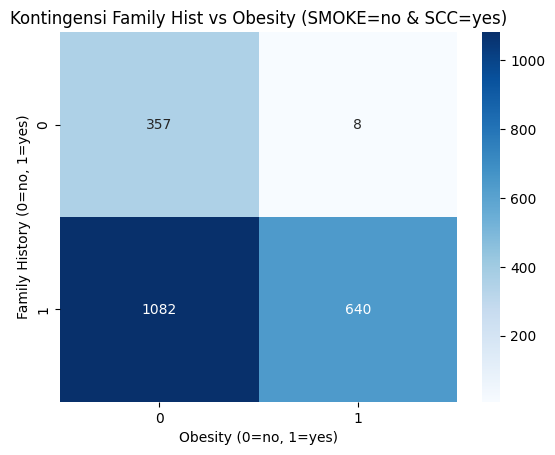

In [18]:
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Obesity (0=no, 1=yes)')
plt.ylabel('Family History (0=no, 1=yes)')
plt.title('Kontingensi Family Hist vs Obesity (SMOKE=no & SCC=yes)')
plt.show()

setelah dilakukan uji korelasi dan menampilkan heatmap didapati bahwa orang yang keluarganya memiliki riwayat obesitas masih beresiko lebih tinggi terkena obesitas meskipun memiliki pola hidup sehat. dari heatmap diatas terbukti bahwa 640 orang terkena dari 1722 yang memiliki family history obesitas dibanding 8 orang yang tidak memiliki obesitas.

## 4. apakah ada korelasi antara seberapa sering minum alkohol dengan tingkat obsistas yang dimiliki

In [19]:
df_dupe['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_II    290
Normal_Weight          282
Overweight_Level_I     276
Insufficient_Weight    267
Name: count, dtype: int64

In [20]:
df_dupe['CAEC'].value_counts()

CAEC
Sometimes     1761
Frequently     236
Always          53
no              37
Name: count, dtype: int64

In [21]:
# Encoding frekuensi minum alkohol (CAEC)
mapping_caec = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'yes': 1}
df_dupe['CAEC_num'] = df_dupe['CAEC'].map(mapping_caec)

# Encoding status obesitas berdasarkan NObeyesdad
# Kelompok "Obese": Obesity_Type_I, Obesity_Type_II, Obesity_Type_III
obese_values = ['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
df_dupe['Obese'] = df_dupe['NObeyesdad'].apply(lambda x: 1 if x in obese_values else 0)

# Hitung korelasi Pearson
corr = df_dupe['CAEC_num'].corr(df_dupe['Obese'], method='pearson')
print(f"Korelasi CAEC vs Obesitas (Obese=1 untuk tipe obesitas I‑III): {corr:.2f}")

# Statistik deskriptif menurut status obesitas
desc = df_dupe.groupby('Obese')['CAEC_num'].describe()
print("\nDeskriptif frekuensi minum alkohol berdasarkan status obesitas:")
print(desc)

Korelasi CAEC vs Obesitas (Obese=1 untuk tipe obesitas I‑III): -0.25

Deskriptif frekuensi minum alkohol berdasarkan status obesitas:
        count      mean       std  min  25%  50%  75%  max
Obese                                                     
0      1070.0  1.180374  0.462016  0.0  1.0  1.0  1.0  2.0
1       964.0  1.006224  0.101713  0.0  1.0  1.0  1.0  2.0


dari hasil uji korelasi diatas didapati bahwa hubungan antara frequensi minum akohol tidak ada korelasi nya dengan peningkatan tipe obesitas. untuk lebih mengetauhi distribusi datanya selanjutnya kita akan menampilkan distribusi datanya dengan menggunakan boxplot

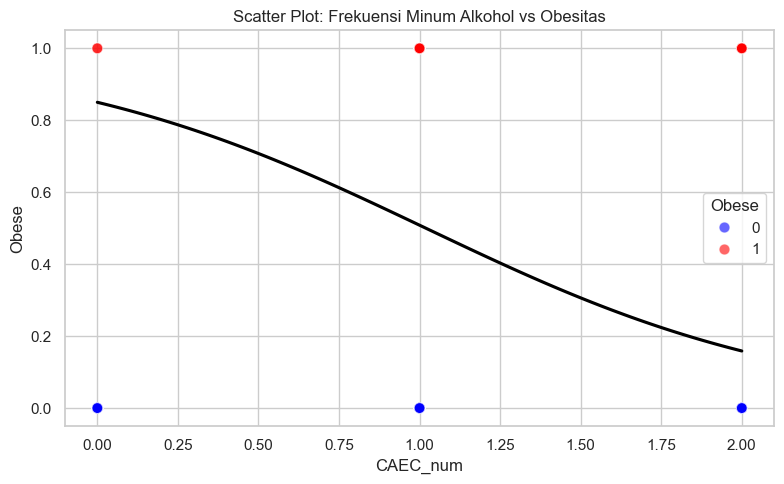

In [22]:
# Atur gaya seaborn
sns.set(style='whitegrid')

# Buat scatter plot
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    data=df_dupe,
    x=df_dupe['CAEC_num'],
    y=df_dupe['Obese'],
    hue='Obese',
    palette={0: 'blue', 1: 'red'},
    alpha=0.6,
    s=60
)
ax.set_xlabel('Frekuensi Minum Alkohol (encoded)')
ax.set_ylabel('Status Obesitas (0 = tidak, 1 = ya)')
ax.set_title('Scatter Plot: Frekuensi Minum Alkohol vs Obesitas')

# Tambahkan garis rata-rata atau regresi
sns.regplot(
    data=df_dupe,
    x=df_dupe['CAEC_num'],
    y=df_dupe['Obese'],
    scatter=False,
    logistic=True,
    ax=ax,
    color='black',
    ci=None
)

plt.legend(title='Obese')
plt.tight_layout()
plt.show()

dilihat dari plot distribusi diatas dan uji korelasi sebelumnya dapat disimpulkan bahwa frequensi minum alkohol tidak ada kaitannya dengan kenaikan tingkat obesitas ini bisa dilihat dari score korelasi ( - 0.25 )

## 5. apakah ada korelasi antara Berapa banyak waktu yang Anda gunakan untuk menggunakan perangkat teknologi seperti ponsel, videogame, televisi, komputer, dan lainnya dengan tingkat obsistas

In [23]:
df_dupe['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_II    290
Normal_Weight          282
Overweight_Level_I     276
Insufficient_Weight    267
Name: count, dtype: int64

In [24]:
df_dupe['TUE'].value_counts()

TUE
0.000000    537
1.000000    289
2.000000    108
0.630866      4
1.119877      3
           ... 
0.091711      1
0.178301      1
0.171034      1
0.097760      1
0.813235      1
Name: count, Length: 1129, dtype: int64

In [25]:
#encode obesity level untuk diuji
df_dupe['obesity_label'] = df_dupe['NObeyesdad'].astype('category').cat.codes

In [26]:
# uji korelasi antara Ture dengan obesity label
corr = df_dupe['TUE'].corr(df_dupe['obesity_label'], method='spearman')
print(f"spearman = {corr:.3f}")

spearman = -0.052


dari uji korelasi diatas didapati bahwa korelasi antara lamanya penggunaan perangkat tidak ada kaitanya dengan kenaikann tingkat obesitas. untuk analisa lebih lanjut menggunakan plot dibawah

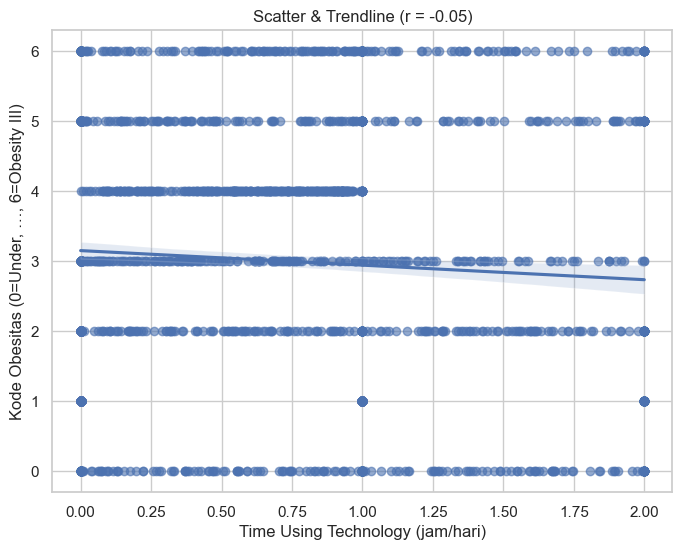

In [27]:

plt.figure(figsize=(8,6))
sns.regplot(x='TUE', y='obesity_label', data=df_dupe, scatter_kws={'alpha':0.6})
plt.xlabel('Time Using Technology (jam/hari)')
plt.ylabel('Kode Obesitas (0=Under, …, 6=Obesity III)')
plt.title(f"Scatter & Trendline (r = {corr:.2f})")
plt.show()

dari hasil korelasi dan plot dapat disimpulkan bahwa korelasi lemah antara lamanya penggunaan teknologi dengan kenaikan tingkat obesitas. bisa dilihat dari hasil korelasi (-0.06) dan dari trendline yang disajikan (korelasi negatif). jadi kolom menggunakan teknologi tidak bisa bisa berdiri sendiri untuk dilakukan uji korelasi harus digabung dengan kolom lain misalkan konsumsi alkohol.

## 6. Distribusi dari kolom Target

In [28]:
df_dupe['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_II    290
Normal_Weight          282
Overweight_Level_I     276
Insufficient_Weight    267
Name: count, dtype: int64

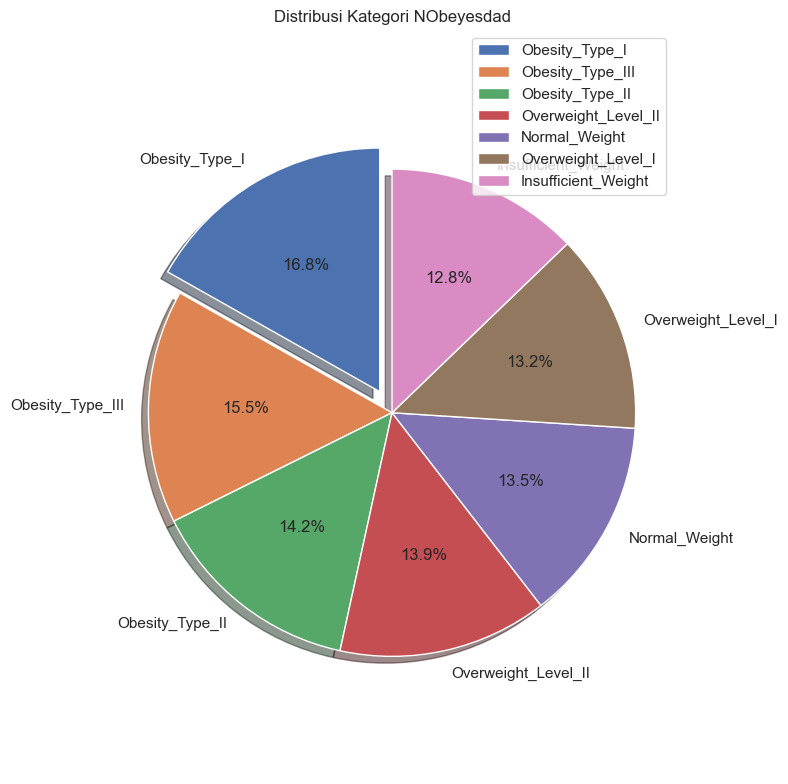

In [29]:
# Data target
labels = [
    'Obesity_Type_I',
    'Obesity_Type_III',
    'Obesity_Type_II',
    'Overweight_Level_II',
    'Normal_Weight',
    'Overweight_Level_I',
    'Insufficient_Weight'
]
sizes = np.array([351, 324, 297, 290, 282, 276, 267])


explode = [0.1] + [0]*6  

plt.figure(figsize=(8,8))
plt.pie(
    sizes,
    labels=labels,
    explode=explode,           
    autopct='%1.1f%%',         
    startangle=90,             
    shadow=True                
)
plt.axis('equal') 
plt.title('Distribusi Kategori NObeyesdad')
plt.legend(loc='best')  
plt.tight_layout()
plt.show()

| Kategori                 | Jumlah | Persentase (%) |
|-------------------------|-------:|---------------:|
| Obesity_Type_I          |    351 |          17.57 |
| Obesity_Type_III        |    324 |          16.22 |
| Obesity_Type_II         |    297 |          14.86 |
| Overweight_Level_II     |    290 |          14.51 |
| Normal_Weight           |    282 |          14.11 |
| Overweight_Level_I      |    276 |          13.80 |
| Insufficient_Weight     |    267 |          13.35 |
| **Total**               |  2,087 |         100.00 |


tabel distribusi dari target bisa dilihat pada table diatas 

## 7. apakah mereka yang memakan kalori tinggi tapi minum banyak bisa mempengaruhi tingkat obesitas?

In [30]:
df_dupe['FAVC'].value_counts()

FAVC
yes    1844
no      243
Name: count, dtype: int64

In [31]:
df_dupe['CH2O'].value_counts()

CH2O
2.000000    445
1.000000    204
3.000000    148
1.636326      3
2.825629      3
           ... 
2.722276      1
2.634342      1
2.619390      1
2.786780      1
2.863513      1
Name: count, Length: 1268, dtype: int64

In [32]:
ord_map = {"Insufficient_Weight":0,"Normal_Weight":1,"Overweight_Level_I":2,
           "Overweight_Level_II":3,"Obesity_Type_I":4,"Obesity_Type_II":5,"Obesity_Type_III":6}
df["N_ob"] = df["NObeyesdad"].map(ord_map)
df["F"] = df["FAVC"].map({"no":0,"yes":1})
df["C"] = df["CH2O"].astype(float)

# Hitung korelasi
rho = df["C"].corr(df["N_ob"], method="spearman")       # Spearman untuk kontinu vs ordinal :contentReference[oaicite:1]{index=1}
r_pb = df["F"].corr(df["N_ob"], method="pearson")

print(f"Spearman CH2O–Ob: {rho:.2f}")
print(f"pearson FAVC–Ob: {r_pb:.2f}")


Spearman CH2O–Ob: 0.15
pearson FAVC–Ob: 0.25


hasil uji korelasi:
- banyak nya konsumsi air dengan peningkatan tingkat obesitas (sangat lemah). jadinya tidak ada hubungan dengan peningkataan tingkat obesitas
- makan kalori tinggi dengan peningkatan tingkat obesitas (lemah). jadinya ada hubungan meskipun lemah jadi harus ada kolom pendukung selain makan dengan kalori tinggi untuk meningkatkan nilai korelasi

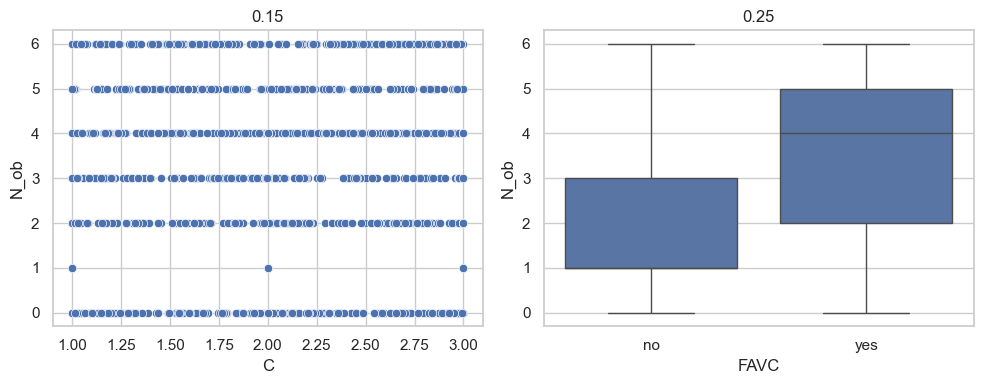

In [33]:
# Visualisasi hasil
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(x="C", y="N_ob", data=df, ax=ax1).set_title(f"{rho:.2f}")
sns.boxplot(x="FAVC", y="N_ob", data=df, ax=ax2).set_title(f"{r_pb:.2f}")
plt.tight_layout()
plt.show()

Minum banyak air sendiri tidak cukup sebagai faktor uji terhadap obesitas.

Mengonsumsi makanan tinggi kalori memang berkaitan dengan peningkatan obesitas, namun hanya memberikan efek kecil – artinya, faktor lain seperti  aktivitas fisik, usia, dan genetik kemungkinan bermain peran lebih besar.



> kesimpulan
 
1. Faktor genetik (family history) adalah yang paling kuat terkait obesitas, jauh lebih signifikan dibanding kebiasaan seperti merokok, minum alkohol, atau penggunaan teknologi.

2. Pola makan tinggi kalori dan monitoring kalori menunjukkan hubungan positif — walau lemah — dengan obesitas dan aktivitas fisik. Ini mengindikasikan keterkaitan antara awareness caloric intake dan gaya hidup aktif.

3. Variabel perilaku lainnya (merokok, alkohol, konsumsi air, penggunaan teknologi) memiliki korelasi yang sangat lemah atau tidak signifikan terhadap obesitas, sehingga tidak bisa dijadikan acuan utama dalam analisis.

4. Data distribusi menunjukkan bahwa populasi ini memiliki proporsi obesitas (tipe I–III) cukup besar (~48%), sehingga intervensi periode mendesak diperlukan.

> insight:

Disarankan untuk membangun model multivariat yang mencakup kombinasi multiple variabel (family history, kalori masuk, aktivitas fisik, dan faktor perilaku) untuk memprediksi obesitas dengan lebih baik.

# Feature Engineering

## Handling Cardinality

In [34]:
cols_to_drop = [
    'SCC_bin',
    'obesity_bin',
    'fam_bin',
    'CAEC_num',
    'Obese',
    'obesity_label'
]

# 1️⃣ Metode langsung (in-place)
df_dupe.drop(columns=cols_to_drop, inplace=True, errors='ignore')
# errors='ignore' agar aman jika ada kolom yang tidak ditemukan

dropping column ini dilakukan karena kolom baru yang terbentunk saat EDA pakai dataset yang sama dengan  pembuatan model. jadi di drop 

In [35]:
pd.set_option('display.max_colwidth', None)

exclude = {'NObeyesdad','CAEC','CALC'}
cat_cols = [c for c in df_dupe.select_dtypes(include='object').columns
            if c not in exclude]

listItem = []
for col in cat_cols:
  listItem.append([col, df_dupe[col].nunique(), df_dupe[col].unique()])

pd.DataFrame(columns=['nama kolom', 'jumlah nilai unique', 'nilai unique'], data=listItem)

,nama kolom,jumlah nilai unique,nilai unique
0,Gender,2,"[Female, Male]"
1,family_history_with_overweight,2,"[yes, no]"
2,FAVC,2,"[no, yes]"
3,SMOKE,2,"[no, yes]"
4,SCC,2,"[no, yes]"
5,MTRANS,5,"[Public_Transportation, Walking, Automobile, Motorbike, Bike]"


menampilkan kolom kategorikal untuk melihat cardinality nya. cardinality yang tinggi bisa membuat model tidak efektif sehingga harus di lakukan pengecekan .

## Split Betweet X (Features) and Y (target)

In [36]:
# pisahkan bagian fitur dan target
x = df_dupe.drop(['NObeyesdad'], axis=1) # features
y = df_dupe[['NObeyesdad']] # target

x

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation
2083,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation
2084,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation
2085,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation


pisahkan kolom x (fitur) dengan kolom y (target), agar bisa dipisah menjadi train dan test set

In [37]:
y.value_counts()

NObeyesdad         
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_II    290
Normal_Weight          282
Overweight_Level_I     276
Insufficient_Weight    267
Name: count, dtype: int64

In [38]:
x.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation


## Splitting between Train Set and Test set

In [39]:
# split x train, test dengan y train, test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 44, stratify=y)
print('Train Size', x_train.shape)
print('Test Size', x_test.shape)

Train Size (1669, 16)
Test Size (418, 16)


Dataset awalnya memiliki 2.087 baris dan 16 kolom fitur dibagi menjadi:

- 1.669 baris untuk data training (digunakan untuk melatih model), dan

- 418 baris untuk data testing (digunakan untuk mengevaluasi performa model).

- Kedua subset tetap memiliki 16 kolom, karena hanya barisnya yang dibagi 

Tujuan pembagian ini adalah agar model bisa belajar dari data training, lalu diuji secara objektif pada data testing yang belum pernah “dilihat” model sebelumnya, sehingga meminimalkan risiko overfitting .

## Encoding Target (Ordinal)

In [40]:
# Ordinal Encoding Kolom Target (y)
target_category_order = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]
target_encoder = OrdinalEncoder(categories=[target_category_order], dtype=int)
y_train_encoded = target_encoder.fit_transform(y_train).ravel()
y_test_encoded = target_encoder.transform(y_test).ravel()

target dilakukan encode terlebih dahulu karena model tidak bisa menerima selain input numerik untuk dilakukan test terhadap model. train dilakukan fit.transform sedangkan test hanya dilakukan transform.

## Handling Outliers

In [41]:
# pisahkan numcols
num_cols = x_train.select_dtypes(include=np.number).columns.to_list()


num_cols

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [42]:
listItem= []

for col in num_cols:
  listItem.append([col, round(x_train[col].skew(),1), np.where(
    (round(x_train[col].skew(),1) <= 0.5) & (round(x_train[col].skew(),1) >= -0.5),
    'normal','skewed')])



skewness = pd.DataFrame(columns=['nama kolom', 'nilai skewness', 'distribution'], data= listItem)
skewness

,nama kolom,nilai skewness,distribution
0,Age,1.5,skewed
1,Height,-0.0,normal
2,Weight,0.3,normal
3,FCVC,-0.4,normal
4,NCP,-1.1,skewed
5,CH2O,-0.1,normal
6,FAF,0.5,normal
7,TUE,0.6,skewed


 beberapa variabel (Age, NCP, TUE) memiliki distribusi yang miring (skewed), sementara sisanya cukup simetris (normal). Nilai skewness di bawah ±0.5 dianggap simetris, sedangkan di luar rentang dekat ±1 menunjukkan kemiringan yang jelas

In [43]:
# Get upper, lower boundaries and percentage of outliers

column = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range (0, len(skewness)):
  col = skewness['nama kolom'][row]
  #checking upper and lower boundary
  if skewness['distribution'][row] == 'skewed':
    IQR = x_train[col].quantile(0.75) - x_train[col].quantile(0.25)
    lower_boundary = x_train[col].quantile(0.25) - (IQR * 3)
    upper_boundary = x_train[col].quantile(0.75) + (IQR * 3)
  else:
    lower_boundary = x_train[col].mean() - 3* x_train[col].std()
    upper_boundary = x_train[col].mean() + 3* x_train[col].std()
  #append to list
  column.append(col)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(x_train[x_train[col] > upper_boundary]) / len(x_train) * 100) + (len(x_train[x_train[col] < lower_boundary]) / len(x_train) * 100))
  percent_total_outlier.append(totout)

outliers = pd.DataFrame({
    'column': column,
    #round the value
    'upper_boundary': [round(upper_bound,2) for upper_bound in upper_bound],
    'lower_boundary': [round(lower_bound,2) for lower_bound in lower_bound],
    'percentage_total_outlier': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})
outliers

,column,upper_boundary,lower_boundary,percentage_total_outlier
0,Age,44.42,1.44,0.84
1,Height,1.98,1.42,0.00
2,Weight,165.85,8.15,0.06
3,FCVC,4.02,0.83,0.00
4,NCP,4.12,1.51,14.98
5,CH2O,3.83,0.20,0.00
6,FAF,3.55,-1.55,0.00
7,TUE,4.00,-3.00,0.00


menghitung batas deteksi outlier memakai metode Interquartile Range (IQR)—menentukan upper_boundary (Q3 + 1.5×IQR) dan lower_boundary (Q1 – 1.5×IQR)kemudian menghitung persentase nilai yang terletak di luar rentang tersebut untuk tiap kolom numerik:

- Age, nilai luar rentang (<1.44 atau >44.42) hanya sekitar 0,84 %;
- NCP memiliki ~14,98 % nilai yang dianggap ekstrem;
- Kolom lain seperti Height, CH2O, FAF, dan TUE tidak memiliki outlier sama sekali (0 %).

In [44]:
# tampilkan statistik dari masing masing kolom numerik 
x_train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Age,1669.0,24.35,6.43,14.00,19.86,22.83,26.00,61.00
Height,1669.0,1.70,0.09,1.45,1.63,1.70,1.77,1.98
Weight,1669.0,87.00,26.28,39.00,66.00,83.12,108.16,173.00
FCVC,1669.0,2.42,0.53,1.00,2.00,2.40,3.00,3.00
NCP,1669.0,2.68,0.78,1.00,2.63,3.00,3.00,4.00
CH2O,1669.0,2.01,0.61,1.00,1.62,2.00,2.47,3.00
FAF,1669.0,1.00,0.85,0.00,0.12,1.00,1.66,3.00
TUE,1669.0,0.65,0.60,0.00,0.00,0.61,1.00,2.00


In [45]:
# lakukan metode capping terhadap kolom dengan presentase outlier yang besar 
winsoriser = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=3,
                            variables=['NCP'])

capping dengan menggunakan winsorizer karena Winsorization tidak membuang baris; sebaliknya, nilai ekstrem diganti dengan batas nilai yang masih masuk akal. Ini menjaga ukuran dataset tetap sama dan mencegah "collateral damage" yang terjadi saat melakukan pemotongan data di kolom terkait. 

Metode Interquartile Range (IQR) lebih tahan terhadap nilai ekstrem dibandingkan rata‑rata dan standar deviasi. Dengan basis Q1 dan Q3, metode ini mendeteksi outlier secara lebih akurat tanpa terpengaruh oleh data ekstrem lainnya.

kolom NCP dilakukan capping karena total outlier dari kolom tersebut melebih tresshold aman (dengan asumsi tresshold 5%)

## Handling missing value

In [46]:
#cek misisng value terhadap x train
x_train.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

In [47]:
#cek misisng value terhadap x test
x_test.isna().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

setelah dilakukan pencarian missing value. tidak terdapat missing value dari kolom fitur. sehingga tidak perlu di handling

## Split Between Numeric Columns and Categorical Columns

In [48]:
# pisah kategorikal ordinal dengan kategorikal nominal
cat_cols_ordinal = ['CAEC', 'CALC']
# Get the numerical and categorical columns
print('Numerical Columns : ', num_cols)
print('Categorical Nominal Columns : ', cat_cols)
print('Categorical Ordinal Columns : ', cat_cols_ordinal)

Numerical Columns :  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical Nominal Columns :  ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']
Categorical Ordinal Columns :  ['CAEC', 'CALC']


pisahkan masing masing kolom untuk selanjuta bisa dilakukan pengecekan di fitur selection dan pembuatan pipeline

## Feature Selection

In [49]:
# Feature numerikal vs kategorikal ordinal target
p_values = []
interpretasi = []
cols = []

for col in num_cols:
  corr_coef, p_value = kendalltau(x_train[col], y_train_encoded)

  p_values.append(p_value)
  cols.append(col)

  if p_value < 0.05:
    interpretasi.append('ada korelasi')
  else :
    interpretasi.append('ga ada korelasi')

pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,Age,ada korelasi
1,Height,ada korelasi
2,Weight,ada korelasi
3,FCVC,ada korelasi
4,NCP,ga ada korelasi
5,CH2O,ada korelasi
6,FAF,ada korelasi
7,TUE,ada korelasi


setelah dilakukan uji korelasi terhadap kolom target. didapat satu kolom NCP yang tidak ada korelasi. namun tetap akan dipakai untuk pengujian model agar terdapat keberagaman kondisi saat dilakukan model inference

In [50]:
# Feature kategorikal ordinal  vs kategorikal ordinal  target
p_values = []
interpretasi = []
cols = []

for col in cat_cols_ordinal:
    # Membuat tabel kontingensi antara feature dan target
    contingency_table = pd.crosstab(x_train[col], y_train_encoded)
    
    # Melakukan uji chi-square
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    p_values.append(p_value)
    cols.append(col)
    
    if p_value < 0.05:
        interpretasi.append('ada asosiasi')
    else:
        interpretasi.append('tidak ada asosiasi')

# Hasil dataframe
hasil_chi2 = pd.DataFrame({
    'nama kolom': cols,
    'p-value': p_values,
    'hasil': interpretasi
})

hasil_chi2

,nama kolom,p-value,hasil
0,CAEC,3.985163e-114,ada asosiasi
1,CALC,3.867514e-46,ada asosiasi


dari 2 kolom ordinal diatas, setelah dilakukan test korelasi semuanya ada asosiasinya . sehingga akan dimasukkan ke model

In [51]:
# Feature kategorikal nominal  vs kategorikal ordinal  target
p_values = []
interpretasi = []
cols = []

for col in cat_cols:
    # Membuat tabel kontingensi antara feature dan target
    contingency_table = pd.crosstab(x_train[col], y_train_encoded)
    
    # Melakukan uji chi-square
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    p_values.append(p_value)
    cols.append(col)
    
    if p_value < 0.05:
        interpretasi.append('ada asosiasi')
    else:
        interpretasi.append('tidak ada asosiasi')

# Hasil dataframe
hasil_chi2 = pd.DataFrame({
    'nama kolom': cols,
    'p-value': p_values,
    'hasil': interpretasi
})

hasil_chi2

,nama kolom,p-value,hasil
0,Gender,1.389123e-111,ada asosiasi
1,family_history_with_overweight,4.967594e-104,ada asosiasi
2,FAVC,5.016069e-35,ada asosiasi
3,SMOKE,2.644887e-03,ada asosiasi
4,SCC,3.693089e-20,ada asosiasi
5,MTRANS,3.774550e-35,ada asosiasi


dari kolom kategorikal diatas, setelah dilakukan test korelasi semuanya ada asosiasinya . sehingga akan dimasukkan ke model

## Data Balancing

In [52]:
# Check distribution of target class on our train set
print(pd.Series(y_train_encoded).value_counts())
print(pd.Series(y_train_encoded).value_counts(normalize=True))

4    281
6    259
5    237
3    232
1    225
2    221
0    214
Name: count, dtype: int64
4    0.168364
6    0.155183
5    0.142001
3    0.139005
1    0.134811
2    0.132415
0    0.128220
Name: proportion, dtype: float64


lakukan pengecekan dari y train encoded. bisa lihat distribusi data target. target 4 memiliki nilai terbanyak sehingga label label lainya akan dilakukan oversampling mengikuti label 4  yaitu berjumlah 281 data

In [53]:

smoteNC = SMOTENC(
    categorical_features=['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS','CAEC', 'CALC'],
    sampling_strategy={0:281,1:281,2:281,3:281,5:281,6:281},
    random_state=44
)
Xb, yb = smoteNC.fit_resample(x_train, y_train_encoded)

SMOTENC membuat data latih lebih seimbang dengan menghasilkan sampel sintetis untuk kelas minoritas, tanpa merusak data kategorikal, sehingga model yang dibangun di atasnya jadi lebih merata dan akurat terhadap semua kelas.

In [54]:
# Check distribution of target class on our train set
print(pd.Series(yb).value_counts())
print(pd.Series(yb).value_counts(normalize=True))

1    281
4    281
6    281
2    281
0    281
3    281
5    281
Name: count, dtype: int64
1    0.142857
4    0.142857
6    0.142857
2    0.142857
0    0.142857
3    0.142857
5    0.142857
Name: proportion, dtype: float64


setelah dilakukan smoteNC semua label sudah tidak lagi terdapat imbalance dan akan lanjut ke dalam proses pembuatan pipeline dan preprosessing

## Pipeline

In [55]:

# scalling numerikal columns
scaler = StandardScaler()

# encode kategorikal nominal  columns
encoder1 = OneHotEncoder(sparse_output=False)

# encode kategorikal nominal  columns
# Definisikan urutan kategori yang sama untuk ketiga kolom
ordinal_categories = ['no', 'Sometimes', 'Frequently', 'Always']
encoder2 = OrdinalEncoder(categories=[ordinal_categories,ordinal_categories])



- standardScaler : digunakan karena dapat menstandard kan kolom numerikal sehingga setiap fitur memiliki rata‑rata 0 dan deviasi standar 1, Memfasilitasi konvergensi pelatihan dengan lebih cepat dan stabil

- OneHotEncoder  : encoder ini dapat mencegah kolom nominal palsu (kolom ordinal). sehingga dapat mempengaruhi kinerja model

- OrdinalEncoder : encoder ini dapat mengubah berdasarkan relasi (kekuatan data)


In [56]:
#  buat FE pipe line

# Numerical pipeline
num_pipe = sklPipeline([
    ('Capping', winsoriser),
    ('scaling', scaler)
])

# categorical nominal  pipeline
cat_pipe = sklPipeline([
    ('Encode', encoder1)
])

# categorical ordinal pipeline
cat_ordinal_pipe = sklPipeline([
    ('Encode2', encoder2)
])

buat FE pipeline dan pisahkan sesuai jenis kolom. sklPipeline pada scikit learn digunakan untuk proses transformasi didalam column transformer.

In [57]:
# buat kolom transformer
preprocess = ColumnTransformer([
    ('numeric', num_pipe, num_cols),
    ('nominal', cat_pipe, cat_cols),
    ('ordinal', cat_ordinal_pipe, cat_cols_ordinal),
])

setelah kolom FE dibuat kemudian dimasukkan kedalam satu kolom yang namanya **ColumnTransformer**. disini semua proses terjadi

# Model Definition

In [58]:
# buat model

Knn = KNeighborsClassifier()
Svc= SVC(probability=True, random_state=44)
Dt= DecisionTreeClassifier(random_state=44)
Rf= RandomForestClassifier(random_state=44)
Gb= GradientBoostingClassifier(random_state=44)

define masing masing model untuk dilakukan testing terhadap data  yang ada

In [59]:
#hubungkan preproses dengan model
pipe_Knn = imbPipeline([('SMOTE',smoteNC),
                        ('fe', preprocess),
                        ('KNN', Knn)])

pipe_Svc = imbPipeline([('SMOTE',smoteNC),
                        ('fe', preprocess),
                        ('SVC', Svc)])

pipe_Dt = imbPipeline([('SMOTE',smoteNC),
                       ('fe', preprocess),
                       ('DT', Dt)])

pipe_Rf = imbPipeline([('SMOTE',smoteNC),
                       ('fe', preprocess),
                       ('RF', Rf)])

pipe_Gb = imbPipeline([('SMOTE',smoteNC),
                       ('fe', preprocess),
                       ('GB', Gb)])


setelah model di define selanjutnya sambungkan model ke pipeline agar bisa dihubungkan dengan FE pipeline sebelumnya . kenapa menggunakan imbPipeline karena saya menggabungkan smoteNC yang berupa sampler bukan transformer ke pipeline jadinya tidak menggunakan sklpipeline

In [60]:
pipe_Knn

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                 ('nominal',
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('KNN', KNeighborsClassifier())])

In [61]:
pipe_Svc

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('SVC', SVC(probability=True, random_state=44))])

In [62]:
pipe_Dt

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('DT', DecisionTreeClassifier(random_state=44))])

In [63]:
pipe_Rf

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('RF', RandomForestClassifier(random_state=44))])

In [64]:
pipe_Gb

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('GB', GradientBoostingClassifier(random_state=44))])

# Model Training

In [65]:
pipe_Knn.fit(x_train,y_train_encoded)

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                 ('nominal',
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('KNN', KNeighborsClassifier())])

In [66]:
pipe_Svc.fit(x_train,y_train_encoded)

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('SVC', SVC(probability=True, random_state=44))])

In [67]:
pipe_Dt.fit(x_train,y_train_encoded)

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('DT', DecisionTreeClassifier(random_state=44))])

In [68]:
pipe_Rf.fit(x_train,y_train_encoded)

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('RF', RandomForestClassifier(random_state=44))])

In [69]:
pipe_Gb.fit(x_train,y_train_encoded)

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                  Pipeline(steps=[('Encode',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('GB', GradientBoostingClassifier(random_state=44))])

# Model Evaluation

## CROSS VAL

### KNeighborclassification

In [70]:
# Check Performance Model against Train-Set

y_pred_train_KNN = pipe_Dt.predict(x_train)

print('F1 Score - Train Set  : ', f1_score(y_train_encoded, y_pred_train_KNN,average='macro'), '\n')
print('Classification Report : \n', classification_report(y_train_encoded, y_pred_train_KNN), '\n')

F1 Score - Train Set  :  1.0 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       221
           3       1.00      1.00      1.00       232
           4       1.00      1.00      1.00       281
           5       1.00      1.00      1.00       237
           6       1.00      1.00      1.00       259

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669
 



In [71]:
# check valscore dari train set model KNN
train_crossval_KNN = cross_val_score(pipe_Dt,
                                     x_train,
                                     y_train_encoded,
                                     cv=3,
                                     scoring="f1_macro")

print('F1 Score - All - Cross Validation  : ', train_crossval_KNN)
print('F1 Score - Mean - Cross Validation : ', train_crossval_KNN.mean())
print('F1 Score - Std - Cross Validation  : ', train_crossval_KNN.std())
print('F1 Score - Range of Test-Set       : ', (train_crossval_KNN.mean()-train_crossval_KNN.std()) , '-', (train_crossval_KNN.mean()+train_crossval_KNN.std()))

F1 Score - All - Cross Validation  :  [0.92338605 0.92637747 0.90003603]
F1 Score - Mean - Cross Validation :  0.9165998518805273
F1 Score - Std - Cross Validation  :  0.011775885511669295
F1 Score - Range of Test-Set       :  0.904823966368858 - 0.9283757373921966


F1 Score - Test Set   :  0.8025223076775366 

Classification Report : 
               precision    recall  f1-score   support

           0       0.76      0.98      0.86        53
           1       0.68      0.30      0.41        57
           2       0.70      0.69      0.70        55
           3       0.81      0.81      0.81        58
           4       0.81      0.96      0.88        70
           5       0.94      1.00      0.97        60
           6       0.98      1.00      0.99        65

    accuracy                           0.83       418
   macro avg       0.81      0.82      0.80       418
weighted avg       0.82      0.83      0.81       418
 

Confusion Matrix      : 


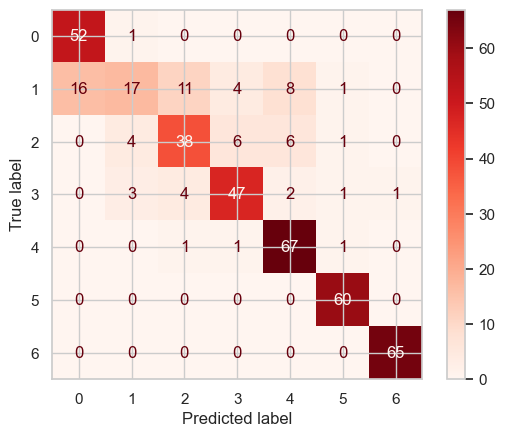

In [72]:
# Check Performance Model against Test-Set

y_pred_test_KNN = pipe_Knn.predict(x_test)

print('F1 Score - Test Set   : ', f1_score(y_test_encoded, y_pred_test_KNN, average='macro'), '\n')
print('Classification Report : \n', classification_report(y_test_encoded, y_pred_test_KNN), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_Knn, x_test, y_test_encoded, cmap='Reds'))

### SVC

In [73]:
# Check Performance Model against Train-Set

y_pred_train_SVC = pipe_Svc.predict(x_train)

print('F1 Score - Train Set  : ', f1_score(y_train_encoded, y_pred_train_SVC,average='macro'), '\n')
print('Classification Report : \n', classification_report(y_train_encoded, y_pred_train_SVC), '\n')

F1 Score - Train Set  :  0.9592154590343933 

Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       214
           1       0.91      0.92      0.92       225
           2       0.89      0.89      0.89       221
           3       0.96      0.94      0.95       232
           4       0.99      0.98      0.98       281
           5       0.98      1.00      0.99       237
           6       1.00      1.00      1.00       259

    accuracy                           0.96      1669
   macro avg       0.96      0.96      0.96      1669
weighted avg       0.96      0.96      0.96      1669
 



In [74]:
# check valscore dari train set model SVC

train_crossval_SVC = cross_val_score(pipe_Svc,
                                     x_train,
                                     y_train_encoded,
                                     cv=3,
                                     scoring="f1_macro")

print('F1 Score - All - Cross Validation  : ', train_crossval_SVC)
print('F1 Score - Mean - Cross Validation : ', train_crossval_SVC.mean())
print('F1 Score - Std - Cross Validation  : ', train_crossval_SVC.std())
print('F1 Score - Range of Test-Set       : ', (train_crossval_SVC.mean()-train_crossval_SVC.std()) , '-', (train_crossval_SVC.mean()+train_crossval_SVC.std()))

F1 Score - All - Cross Validation  :  [0.88339895 0.91086474 0.8697337 ]
F1 Score - Mean - Cross Validation :  0.8879991305685726
F1 Score - Std - Cross Validation  :  0.017103836451742366
F1 Score - Range of Test-Set       :  0.8708952941168302 - 0.905102967020315


F1 Score - Test Set   :  0.9347339609130353 

Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95        53
           1       0.84      0.91      0.87        57
           2       0.88      0.80      0.84        55
           3       0.91      0.91      0.91        58
           4       0.97      0.96      0.96        70
           5       1.00      1.00      1.00        60
           6       1.00      1.00      1.00        65

    accuracy                           0.94       418
   macro avg       0.94      0.94      0.93       418
weighted avg       0.94      0.94      0.94       418
 

Confusion Matrix      : 


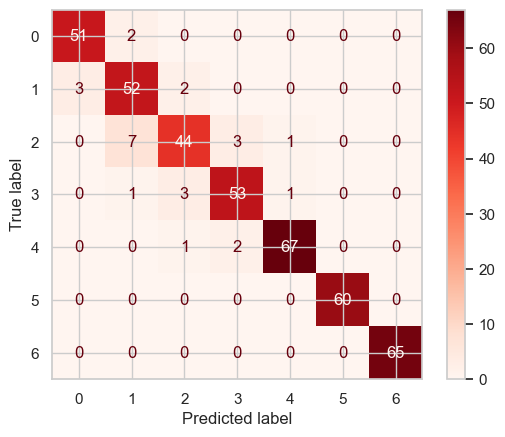

In [75]:
# Check Performance Model against Test-Set

y_pred_test_SVC = pipe_Svc.predict(x_test)

print('F1 Score - Test Set   : ', f1_score(y_test_encoded, y_pred_test_SVC, average='macro'), '\n')
print('Classification Report : \n', classification_report(y_test_encoded, y_pred_test_SVC), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_Svc, x_test, y_test_encoded, cmap='Reds'))

### DecisionTreeClassifier

In [76]:
# Check Performance Model against Train-Set

y_pred_train_DT = pipe_Dt.predict(x_train)

print('F1 Score - Train Set  : ', f1_score(y_train_encoded, y_pred_train_DT,average='macro'), '\n')
print('Classification Report : \n', classification_report(y_train_encoded, y_pred_train_DT), '\n')

F1 Score - Train Set  :  1.0 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       221
           3       1.00      1.00      1.00       232
           4       1.00      1.00      1.00       281
           5       1.00      1.00      1.00       237
           6       1.00      1.00      1.00       259

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669
 



In [77]:
# check valscore dari train set model DT
train_crossval_DT = cross_val_score(pipe_Dt,
                                     x_train,
                                     y_train_encoded,
                                     cv=3,
                                     scoring="f1_macro")

print('F1 Score - All - Cross Validation  : ', train_crossval_DT)
print('F1 Score - Mean - Cross Validation : ', train_crossval_DT.mean())
print('F1 Score - Std - Cross Validation  : ', train_crossval_DT.std())
print('F1 Score - Range of Test-Set       : ', (train_crossval_DT.mean()-train_crossval_DT.std()) , '-', (train_crossval_DT.mean()+train_crossval_DT.std()))

F1 Score - All - Cross Validation  :  [0.92338605 0.92637747 0.90003603]
F1 Score - Mean - Cross Validation :  0.9165998518805273
F1 Score - Std - Cross Validation  :  0.011775885511669295
F1 Score - Range of Test-Set       :  0.904823966368858 - 0.9283757373921966


F1 Score - Test Set   :  0.9317292776437286 

Classification Report : 
               precision    recall  f1-score   support

           0       0.89      0.96      0.93        53
           1       0.89      0.82      0.85        57
           2       0.90      0.84      0.87        55
           3       0.93      0.95      0.94        58
           4       0.95      0.99      0.97        70
           5       0.98      0.97      0.97        60
           6       0.98      1.00      0.99        65

    accuracy                           0.94       418
   macro avg       0.93      0.93      0.93       418
weighted avg       0.93      0.94      0.93       418
 

Confusion Matrix      : 


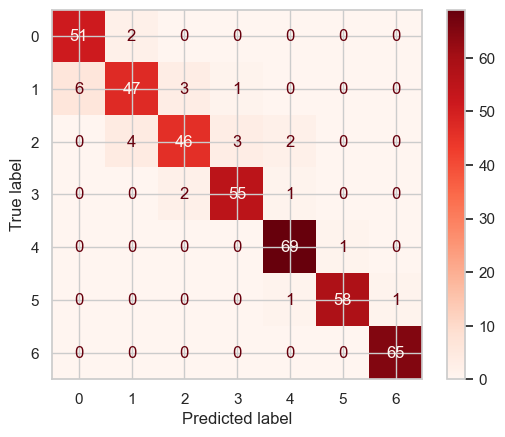

In [78]:
# Check Performance Model against Test-Set

y_pred_test_DT = pipe_Dt.predict(x_test)

print('F1 Score - Test Set   : ', f1_score(y_test_encoded, y_pred_test_DT, average='macro'), '\n')
print('Classification Report : \n', classification_report(y_test_encoded, y_pred_test_DT), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_Dt, x_test, y_test_encoded, cmap='Reds'))

### RandomForestClassifier

In [79]:
# Check Performance Model against Train-Set

y_pred_train_RF = pipe_Rf.predict(x_train)

print('F1 Score - Train Set  : ', f1_score(y_train_encoded, y_pred_train_RF,average='macro'), '\n')
print('Classification Report : \n', classification_report(y_train_encoded, y_pred_train_RF), '\n')

F1 Score - Train Set  :  1.0 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       221
           3       1.00      1.00      1.00       232
           4       1.00      1.00      1.00       281
           5       1.00      1.00      1.00       237
           6       1.00      1.00      1.00       259

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669
 



In [80]:
# check valscore dari train set model RF
train_crossval_RF = cross_val_score(pipe_Rf,
                                     x_train,
                                     y_train_encoded,
                                     cv=3,
                                     scoring="f1_macro")

print('F1 Score - All - Cross Validation  : ', train_crossval_RF)
print('F1 Score - Mean - Cross Validation : ', train_crossval_RF.mean())
print('F1 Score - Std - Cross Validation  : ', train_crossval_RF.std())
print('F1 Score - Range of Test-Set       : ', (train_crossval_RF.mean()-train_crossval_RF.std()) , '-', (train_crossval_RF.mean()+train_crossval_RF.std()))

F1 Score - All - Cross Validation  :  [0.92443903 0.94470484 0.93433341]
F1 Score - Mean - Cross Validation :  0.9344924260151712
F1 Score - Std - Cross Validation  :  0.008274245667442469
F1 Score - Range of Test-Set       :  0.9262181803477287 - 0.9427666716826137


F1 Score - Test Set   :  0.9510912133616338 

Classification Report : 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.81      0.98      0.89        57
           2       0.98      0.84      0.90        55
           3       0.96      0.93      0.95        58
           4       0.97      0.96      0.96        70
           5       1.00      0.98      0.99        60
           6       0.98      1.00      0.99        65

    accuracy                           0.95       418
   macro avg       0.96      0.95      0.95       418
weighted avg       0.96      0.95      0.95       418
 

Confusion Matrix      : 


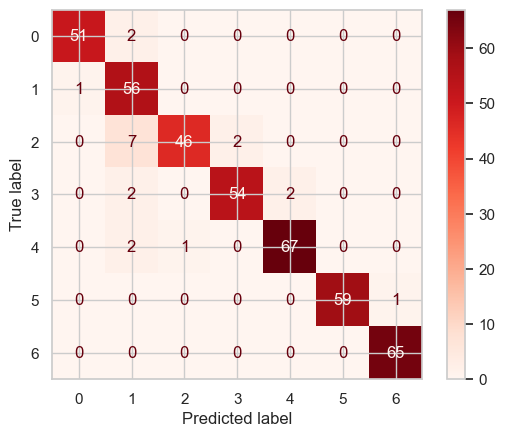

In [81]:
# Check Performance Model against Test-Set

y_pred_test_RF = pipe_Rf.predict(x_test)

print('F1 Score - Test Set   : ', f1_score(y_test_encoded, y_pred_test_RF, average='macro'), '\n')
print('Classification Report : \n', classification_report(y_test_encoded, y_pred_test_RF), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_Rf, x_test, y_test_encoded, cmap='Reds'))

### GradientBoostingClassifier

In [82]:
# Check Performance Model against Train-Set

y_pred_train_GB = pipe_Gb.predict(x_train)

print('F1 Score - Train Set  : ', f1_score(y_train_encoded, y_pred_train_GB,average='macro'), '\n')
print('Classification Report : \n', classification_report(y_train_encoded, y_pred_train_GB), '\n')

F1 Score - Train Set  :  1.0 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       1.00      1.00      1.00       225
           2       1.00      1.00      1.00       221
           3       1.00      1.00      1.00       232
           4       1.00      1.00      1.00       281
           5       1.00      1.00      1.00       237
           6       1.00      1.00      1.00       259

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669
 



In [83]:
# check valscore dari train set model GB
train_crossval_GB = cross_val_score(pipe_Gb,
                                     x_train,
                                     y_train_encoded,
                                     cv=3,
                                     scoring="f1_macro")

print('F1 Score - All - Cross Validation  : ', train_crossval_GB)
print('F1 Score - Mean - Cross Validation : ', train_crossval_GB.mean())
print('F1 Score - Std - Cross Validation  : ', train_crossval_GB.std())
print('F1 Score - Range of Test-Set       : ', (train_crossval_GB.mean()-train_crossval_GB.std()) , '-', (train_crossval_GB.mean()+train_crossval_GB.std()))

F1 Score - All - Cross Validation  :  [0.92798047 0.94051035 0.94091986]
F1 Score - Mean - Cross Validation :  0.9364702257447504
F1 Score - Std - Cross Validation  :  0.006005489768212405
F1 Score - Range of Test-Set       :  0.930464735976538 - 0.9424757155129627


F1 Score - Test Set   :  0.9697100293326635 

Classification Report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        53
           1       0.93      0.95      0.94        57
           2       0.98      0.89      0.93        55
           3       0.97      0.97      0.97        58
           4       0.97      1.00      0.99        70
           5       1.00      0.98      0.99        60
           6       1.00      1.00      1.00        65

    accuracy                           0.97       418
   macro avg       0.97      0.97      0.97       418
weighted avg       0.97      0.97      0.97       418
 

Confusion Matrix      : 


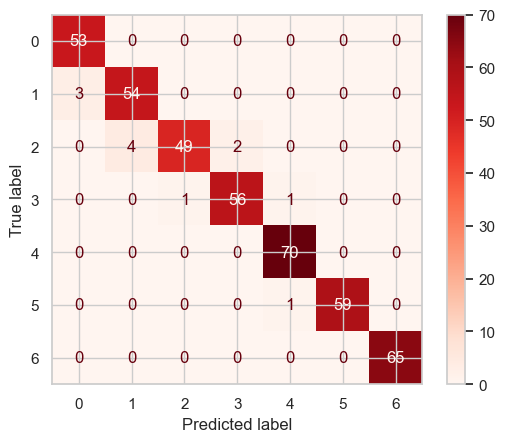

In [84]:
# Check Performance Model against Test-Set

y_pred_test_GB = pipe_Gb.predict(x_test)

print('F1 Score - Test Set   : ', f1_score(y_test_encoded, y_pred_test_GB, average='macro'), '\n')
print('Classification Report : \n', classification_report(y_test_encoded, y_pred_test_GB), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_Gb, x_test, y_test_encoded, cmap='Reds'))

### Hasil Akhir

In [85]:
pd.DataFrame({
    'Model': ['KNN', 'GradientBoosting', 'RandomForest', 'SVC', 'DecisionTree'],
    'F1_train_macro': [
        f1_score(y_train_encoded, y_pred_train_KNN, average='macro'),
        f1_score(y_train_encoded, y_pred_train_GB, average='macro'),
        f1_score(y_train_encoded, y_pred_train_RF, average='macro'),
        f1_score(y_train_encoded, y_pred_train_SVC, average='macro'),
        f1_score(y_train_encoded, y_pred_train_DT, average='macro'),
    ],
    'F1_mean': [
        train_crossval_KNN.mean(),
        train_crossval_GB.mean(),
        train_crossval_RF.mean(),
        train_crossval_SVC.mean(),
        train_crossval_DT.mean(),
    ],
    'F1_std': [
        train_crossval_KNN.std(),
        train_crossval_GB.std(),
        train_crossval_RF.std(),
        train_crossval_SVC.std(),
        train_crossval_DT.std(),
    ],
    
    
}).sort_values(by='F1_std', ascending=True)

,Model,F1_train_macro,F1_mean,F1_std
1,GradientBoosting,1.000000,0.936470,0.006005
2,RandomForest,1.000000,0.934492,0.008274
0,KNN,1.000000,0.916600,0.011776
4,DecisionTree,1.000000,0.916600,0.011776
3,SVC,0.959215,0.887999,0.017104


- dari hasil train set diatas dan analisa dari val score . saya mengambil model gradient boosting untuk dilakukan hyperparameter tuning. 

- kenapa saya  memilih f1 score untuk penilaian saya, karena dataset yang saya test sekarang merupakan classification jadi sangat cocok memakai f1 score

- kenapa saya memilihi model ini karena melihat dari f1 score mean yang paling besar karena semakin besar mean nya berarti semakin bagus performanya

- kebalikannya dengan f1 STD semakin kecil nilainya maka model akan semakin konsisten

jadi model yang diambil adalah **GradientBoosting**	 yang cocok bagi data set multiclass classification yang saya test. karena akurasi tinggi pada data tabular, robust terhadap data outlier sehingga tidak ada data noise

## HYPERPARAMETER TUNING

In [86]:
#define param grid untuk dilakukan tuning
param_grid_GB = {
    'GB__n_estimators': [100, 200, 300],
    'GB__learning_rate': [0.01, 0.05, 0.1],
    'GB__max_depth': [3, 5, 7],
    'GB__subsample': [0.8, 1.0]
}

grid_GB = GridSearchCV(
    estimator=pipe_Gb,
    param_grid=param_grid_GB,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Fit model
grid_GB.fit(x_train, y_train_encoded)

# Hasil terbaik
print("Best params:", grid_GB.best_params_)
print(f"Best CV F1_macro: {grid_GB.best_score_:.3f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best params: {'GB__learning_rate': 0.1, 'GB__max_depth': 5, 'GB__n_estimators': 300, 'GB__subsample': 1.0}
Best CV F1_macro: 0.956


setelah dilakukan uji model dengan hyperparameter tuning. parameter terbaik yang didapat adalah:
- GB__learning_rate': 0.1, 
- 'GB__max_depth': 5, 
- 'GB__n_estimators': 300, 
- 'GB__subsample': 1.0
- dengan f1 mean baru = 0.956

## HYPERPARAMETER TUNING - TRAINING

In [87]:
best_model_GB = grid_GB.best_estimator_
best_model_GB.fit(x_train,y_train_encoded)

Pipeline(steps=[('SMOTE',
                 SMOTENC(categorical_features=['Gender',
                                               'family_history_with_overweight',
                                               'FAVC', 'SMOKE', 'SCC', 'MTRANS',
                                               'CAEC', 'CALC'],
                         random_state=44,
                         sampling_strategy={0: 281, 1: 281, 2: 281, 3: 281,
                                            5: 281, 6: 281})),
                ('fe',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('Capping',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=3,
                                                                              tail='both',
                                                                              variabl...
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'MTRANS']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('Encode2',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always'],
                                                                                              ['no',
                                                                                               'Sometimes',
                                                                                               'Frequently',
                                                                                               'Always']]))]),
                                                  ['CAEC', 'CALC'])])),
                ('GB',
                 GradientBoostingClassifier(max_depth=5, n_estimators=300,
                                            random_state=44))])

## HYPERPARAMETER TUNING - EVALUATION

In [88]:
train_crossval_GB_Tuning = cross_val_score(best_model_GB,
                                     x_train,
                                     y_train_encoded,
                                     cv=3,
                                     scoring="f1_macro")

print('F1 Score - All - Cross Validation  : ', train_crossval_GB_Tuning)
print('F1 Score - Mean - Cross Validation : ', train_crossval_GB_Tuning.mean())
print('F1 Score - Std - Cross Validation  : ', train_crossval_GB_Tuning.std())
print('F1 Score - Range of Test-Set       : ', (train_crossval_GB_Tuning.mean()-train_crossval_GB_Tuning.std()) , '-', (train_crossval_GB_Tuning.mean()+train_crossval_GB_Tuning.std()))

F1 Score - All - Cross Validation  :  [0.94716369 0.95347554 0.96652712]
F1 Score - Mean - Cross Validation :  0.9557221170674762
F1 Score - Std - Cross Validation  :  0.008063123920303557
F1 Score - Range of Test-Set       :  0.9476589931471727 - 0.9637852409877797


F1 Score - Test Set   :  0.9719461362477455 

Classification Report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        53
           1       0.96      0.95      0.96        57
           2       0.98      0.89      0.93        55
           3       0.93      0.97      0.95        58
           4       0.99      1.00      0.99        70
           5       1.00      1.00      1.00        60
           6       1.00      1.00      1.00        65

    accuracy                           0.97       418
   macro avg       0.97      0.97      0.97       418
weighted avg       0.97      0.97      0.97       418
 

Confusion Matrix      : 


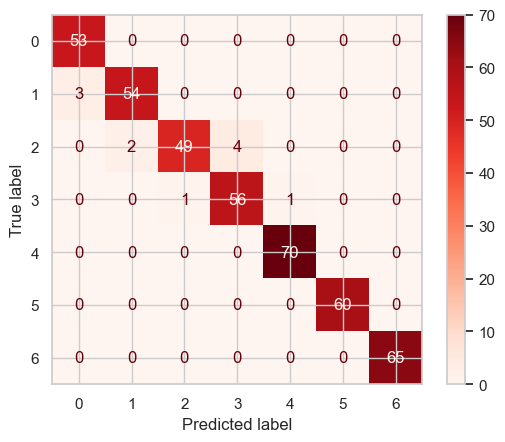

In [89]:
# Check Performance Model against Test-Set

y_pred_test_GB_Tuning = best_model_GB.predict(x_test)

print('F1 Score - Test Set   : ', f1_score(y_test_encoded, y_pred_test_GB_Tuning, average='macro'), '\n')
print('Classification Report : \n', classification_report(y_test_encoded, y_pred_test_GB_Tuning), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(best_model_GB, x_test, y_test_encoded, cmap='Reds'))

## Hasil Akhir - Tuning

In [90]:
pd.DataFrame({
    'Model': ['GradientBoosting (after)', 'GradientBoosting (Before)'],
    'F1_mean': [
        train_crossval_GB_Tuning.mean(),
        train_crossval_GB.mean()
    ],
    'F1_std': [
        train_crossval_GB_Tuning.std(),
        train_crossval_GB.std()
    ],
    'F1_test_Macro': [
        f1_score(y_test_encoded, y_pred_test_GB_Tuning, average='macro'),
        f1_score(y_test_encoded, y_pred_test_GB, average='macro')
    ],
        
    
    
}).sort_values(by='F1_std', ascending=True)

,Model,F1_mean,F1_std,F1_test_Macro
1,GradientBoosting (Before),0.936470,0.006005,0.969710
0,GradientBoosting (after),0.955722,0.008063,0.971946


```
setelah dihitung cross val terhadap test set didapati bahwa ada kenaikan nilai test dibanding nilai f1 test sebelum di tuning 
GradientBoosting (Before)	0.936470	0.006005	0.969710
GradientBoosting (after)	0.955722	0.008063	0.971946

```

# Model Saving

In [91]:
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model_GB, file)

# Model Inference

model inference sudah dilakukan di note ipynnb yang berbeda

# Pengambilan Kesimpulan

pipeline end-to-end yang di bangun—mulai dari eksplorasi data, standardisasi dan encoding fitur, penanganan imbalance dengan SMOTENC, hingga pemilihan serta tuning model Gradient Boosting—telah menghasilkan sebuah sistem klasifikasi yang kuat, stable, dan akurat. Gradient Boosting terbukti:

- Mampu mengolah data tabular dengan berbagai jenis fitur dan representasi kategorikal,

- Tahan terhadap outlier dan noise,

- Memberikan performa tinggi berdasarkan F1-score (yang ideal untuk klasifikasi multikelas dan data tidak seimbang),

- Stabil across cross-validation folds,

- Meningkat lebih lanjut setelah hyperparameter tuning, yang meningkatkan akurasi dan F1-score secara signifikan.

Pendekatan yang sistematis dan metodologis, serta penggunaan metrik yang tepat, menunjukkan bahwa model ini cukup andal untuk digunakan pada aplikasi nyata—terutama dalam domain dengan data tabular kompleks, klasifikasi multikelas, dan kebutuhan akan model yang mudah diinterpretasi.